# 顧客區隔的購買產品分析

In [ ]:
應用顧客區隔的結果分析商品銷售的情形

In [ ]:
1. 分析銷售數量最多的十種商品在顧客區隔的各種集群的銷售比例。
2. 分析顧客區隔的各種集群銷售數量最多的十種商品。

## 載入套件與讀取資料

### 載入套件

In [1]:
# 載入所需套件

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
# 從sklearn套件中，載入KMeans方法
from sklearn.preprocessing import StandardScaler
# 從sklearn套件中，載入KMeans方法
from sklearn.cluster import KMeans

In [2]:
'''
圖形中有中文字型的問題
參考
https://codertw.com/%E7%A8%8B%E5%BC%8F%E8%AA%9E%E8%A8%80/359974/
'''
from matplotlib.font_manager import FontProperties

han_font = FontProperties(fname=r"c:/windows/fonts/msjh.ttc", size=14) # 中文字形

In [3]:
'''
設計圖形呈現的外觀風格
'''
sns.set(style="whitegrid")

### 讀取資料

In [4]:
# 讀入資料檔
df = pd.read_excel('Online Retail.xlsx')

### 資料清理

In [5]:
# 去除CustomerID沒有資料的紀錄
df = df.dropna(subset=['CustomerID'])

In [6]:
from datetime import date

df = df.assign(PurchaseDate=df.InvoiceDate.apply(lambda x: x.date()))

# 取出2010-12-09到2011-12-09一年之間的資料
df = df[df.PurchaseDate>=date(2010, 12, 9)]

In [7]:
#取出購買紀錄(不包含取消紀錄)
df = df[df.Quantity>0] 

### 資料彙整

In [8]:
# 計算發票上物品總價(單價*數量)
df = df.assign(Total=df.UnitPrice*df.Quantity)

## 利用RFM Model進行顧客區隔

### 計算每位顧客的Recency、Frequency和Monetary

In [9]:
# 將計算# Recency的方式寫為函數
def recency(pdate):
    # 計算最近購買日期與2011-12-10的差(pdate.max()是最近的購買日期)
    dt = date(2011,12,10) - pdate.max()
    # dt.days：轉換為以天計算的方式
    return(dt.days)

In [10]:
# 將計算Frequency的方式寫為函數
def frequency(inv):
    return(np.log(inv.nunique()))

In [11]:
#將計算Monetary的方式寫為函數
def monetary(tot):
    return(np.log10(tot.sum()+1))

In [12]:
# 計算每位顧客的Recency、Frequency和Monetary
CustomerData = df.groupby(["CustomerID"]).agg({"PurchaseDate": recency,
                                               "InvoiceNo": frequency,
                                               "Total": monetary}).reset_index()\
.rename(columns={"PurchaseDate": "Recency",
                 "InvoiceNo": "Frequency",
                 "Total": "Monetary"})

### 將Recency、Frequency和Monetary標準化

In [13]:
# 標準化函數
scaler = StandardScaler()

In [14]:
# 將特徵值進行標準化
X = scaler.fit_transform(CustomerData.iloc[:, 1:].values)

### 進行K-means集群分析

In [15]:
# 預設K-means集群演算法參數，將顧客分為5群
km = KMeans(
    n_clusters=5, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
)

In [16]:
# K-means集群的結果
CustomerData = CustomerData.assign(ClusterID=km.fit_predict(X))

In [ ]:
plt.figure(figsize=[10, 5]) #圖的大小
ax = sns.pairplot(CustomerData, vars=["Recency", "Frequency", "Monetary"], hue="ClusterID")

分析各集群顧客的特徵

In [17]:
# 計算各集群的顧客人數
ClusterSize = CustomerData.groupby("ClusterID")["CustomerID"].count().reset_index()

Text(0.5, 1.0, '各集群的顧客人數')

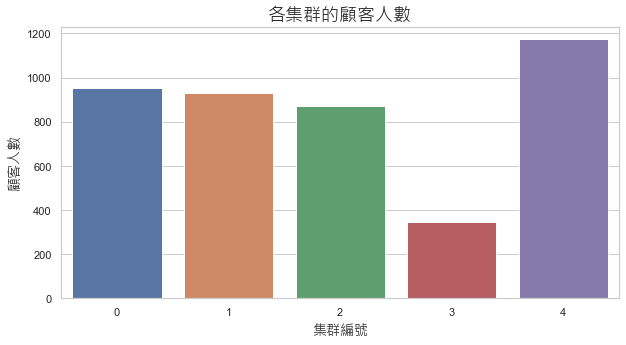

In [54]:
# 以長條圖呈現各集群的顧客人數
plt.figure(figsize=[10, 5])
ax = sns.barplot(x="ClusterID", y="CustomerID", data=ClusterSize)
ax.set_xlabel("集群編號", fontproperties=han_font)
ax.set_ylabel("顧客人數", fontproperties=han_font)
ax.set_title('各集群的顧客人數', fontproperties=han_font, fontsize=18)

In [18]:
# 計算各集群的顧客人數佔全體比例
Percent=np.around(ClusterSize.CustomerID/ClusterSize.CustomerID.sum()*100, 2)

In [19]:
# 將顧客區隔分析的結果與原先的資料合併
df = df.merge(CustomerData[["CustomerID", "ClusterID"]], how="left", on="CustomerID")

## 分析銷售數量最多的十項商品在各種集群顧客的銷售比例

### 統計銷售總數最多的前十項商品

In [20]:
# 依據銷售總數由大到小排列商品
Product_Data = df.groupby("Description")["Quantity"].sum()\
                 .reset_index().sort_values("Quantity", ascending=False)

Text(0.5, 1.0, '銷售總數最多的前10項商品')

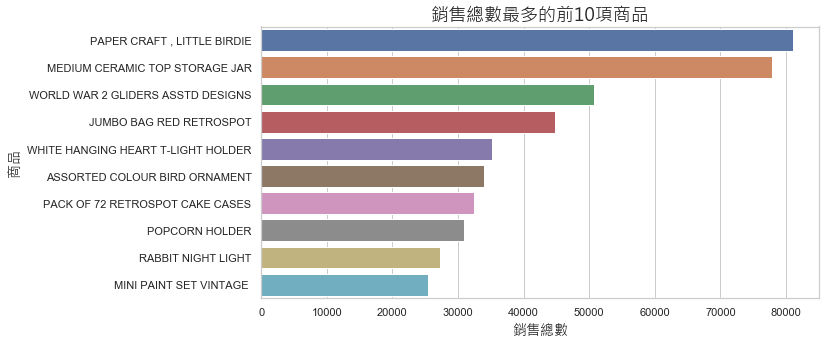

In [64]:
# 以長條圖呈現銷售總數最多的前十項商品
plt.figure(figsize=[10, 5])
ax = sns.barplot(x="Quantity", y="Description", data=Product_Data[:10])
ax.set_xlabel("銷售總數", fontproperties=han_font)
ax.set_ylabel("商品", fontproperties=han_font)
ax.set_title('銷售總數最多的前10項商品', fontproperties=han_font, fontsize=18)

In [21]:
# 銷售總數最多的前十項商品
MajorProducts = Product_Data[:10].Description.values

In [22]:
# 取出銷售總數最多的前十項商品的購買紀錄
mp_df = df[df.Description.isin(MajorProducts)]

In [40]:
# 統計銷售總數最多的前十項商品在各集群顧客的銷售數
Products_byCluster = mp_df.groupby(["Description", "ClusterID"]).Quantity.sum().reset_index()
Products_byCluster

,Description,ClusterID,Quantity
0,ASSORTED COLOUR BIRD ORNAMENT,0,8996
1,ASSORTED COLOUR BIRD ORNAMENT,1,826
2,ASSORTED COLOUR BIRD ORNAMENT,2,1002
3,ASSORTED COLOUR BIRD ORNAMENT,3,18139
4,ASSORTED COLOUR BIRD ORNAMENT,4,5051
5,JUMBO BAG RED RETROSPOT,0,7645
6,JUMBO BAG RED RETROSPOT,1,647
7,JUMBO BAG RED RETROSPOT,2,641
8,JUMBO BAG RED RETROSPOT,3,31362
9,JUMBO BAG RED RETROSPOT,4,4527


In [41]:
# 計算各集群顧客前十項熱銷商品的銷售數佔該商品銷售總數的百分比
Products_byCluster = Products_byCluster.assign(
    Percent=Products_byCluster.groupby("Description")\
    .apply(lambda dat_fra: np.around(dat_fra.Quantity/dat_fra.Quantity.sum()*100, 2))\
    .values)
Products_byCluster

,Description,ClusterID,Quantity,Percent
0,ASSORTED COLOUR BIRD ORNAMENT,0,8996,26.45
1,ASSORTED COLOUR BIRD ORNAMENT,1,826,2.43
2,ASSORTED COLOUR BIRD ORNAMENT,2,1002,2.95
3,ASSORTED COLOUR BIRD ORNAMENT,3,18139,53.33
4,ASSORTED COLOUR BIRD ORNAMENT,4,5051,14.85
5,JUMBO BAG RED RETROSPOT,0,7645,17.06
6,JUMBO BAG RED RETROSPOT,1,647,1.44
7,JUMBO BAG RED RETROSPOT,2,641,1.43
8,JUMBO BAG RED RETROSPOT,3,31362,69.97
9,JUMBO BAG RED RETROSPOT,4,4527,10.10


In [42]:
# 將各項商品展開
Products_byCluster = Products_byCluster\
.pivot(index="ClusterID", columns="Description", values="Percent")\
.fillna(0)\
.reset_index()

Products_byCluster

In [44]:
# 重新改回原來的形式
pc_col = Products_byCluster.columns[1:].values
Products_byCluster = Products_byCluster.melt(id_vars=['ClusterID'], value_vars=pc_col)

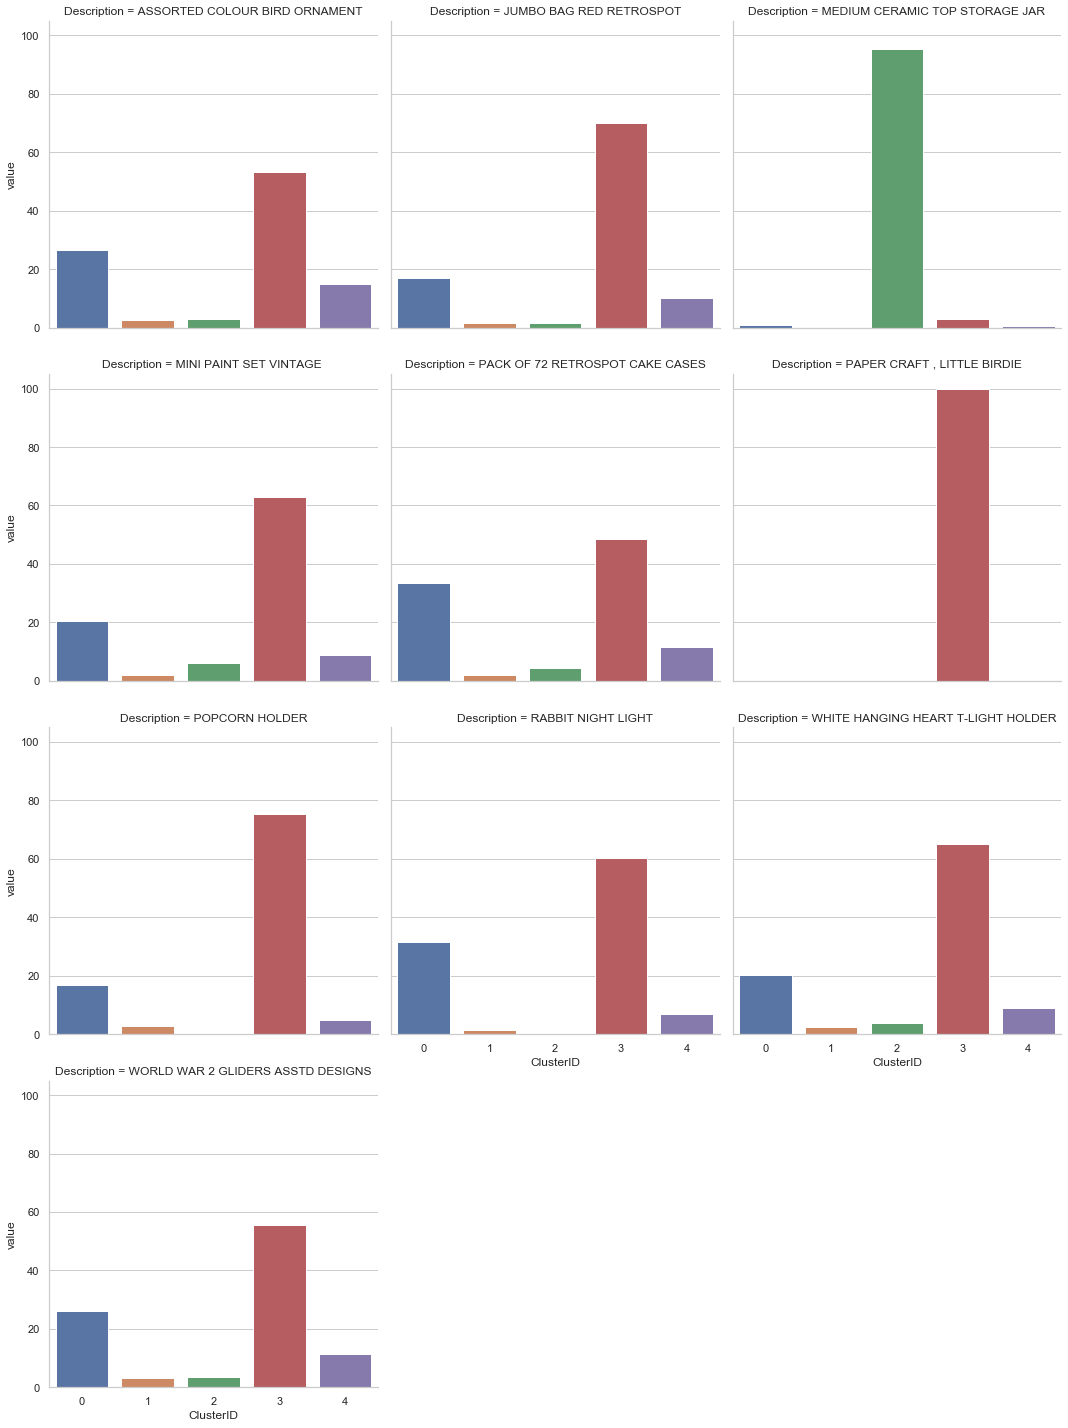

In [53]:
# 將銷售數量最多的十項商品在各種集群顧客的銷售比例畫成長條圖
g = sns.catplot(x="ClusterID", y="value", col="Description", data=Products_byCluster, col_wrap=3,
               kind="bar")

In [ ]:
product_percent = Products_byCluster.values.reshape((Products_byCluster.shape[1], Products_byCluster.shape[0]))

Percent

In [ ]:
from scipy.stats import chisquare

In [ ]:
chisquare(f_obs=product_percent, f_exp=Percent, axis=1)

## 各集群顧客的前十項購買商品

In [60]:
def getTop10Products(ClID):
    return(df[df.ClusterID==ClID].groupby("Description")\
           .Quantity.sum().reset_index()\
           .sort_values("Quantity", ascending=False)[:10])

In [63]:
for i in range(5):
    print(getTop10Products(i))

                             Description  Quantity
3406   WORLD WAR 2 GLIDERS ASSTD DESIGNS     13258
2025     PACK OF 72 RETROSPOT CAKE CASES     10884
2902         SMALL CHINESE STYLE SCISSOR      9417
192        ASSORTED COLOUR BIRD ORNAMENT      8996
2357                  RABBIT NIGHT LIGHT      8583
1576             JUMBO BAG RED RETROSPOT      7645
3325  WHITE HANGING HEART T-LIGHT HOLDER      7071
1248     GIRLS ALPHABET IRON ON PATCHES       6336
98           60 TEATIME FAIRY CAKE CASES      6127
2023  PACK OF 60 PINK PAISLEY CAKE CASES      6065
                              Description  Quantity
186        ASSTD DESIGN 3D PAPER STICKERS     12544
1775           POPART WOODEN PENCILS ASST      1700
2653    WORLD WAR 2 GLIDERS ASSTD DESIGNS      1548
2640   WOODEN STAR CHRISTMAS SCANDINAVIAN      1529
2633  WOODEN HEART CHRISTMAS SCANDINAVIAN      1509
948       GIRLS ALPHABET IRON ON PATCHES       1440
146          ANTIQUE SILVER T-LIGHT GLASS       989
169             ASSORTE